# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.320383,False,0.383705
1,-0.128524,True,5.589229
2,0.242929,False,-0.348551
3,-0.524628,False,-0.041125
4,2.044996,True,7.258376
...,...,...,...
995,1.073343,True,5.591020
996,-0.708004,False,-1.804058
997,0.441290,False,-0.160749
998,-0.342943,True,4.872033


<AxesSubplot:xlabel='v0'>

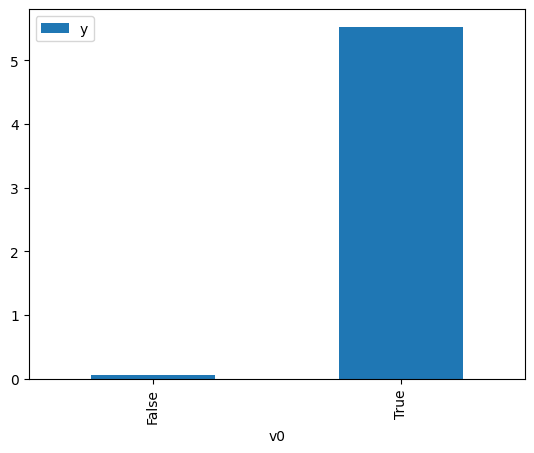

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

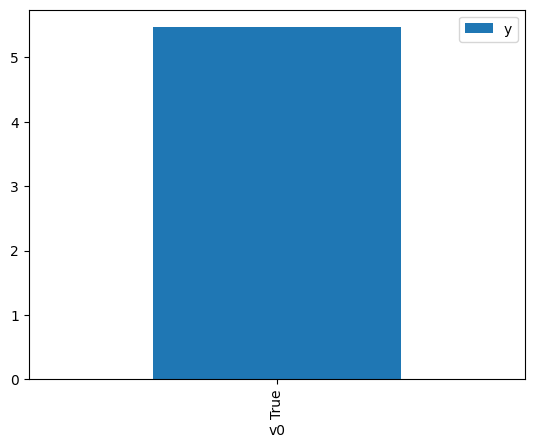

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.315796,False,-0.188084,0.656963,1.522156
1,0.240484,False,0.393972,0.409486,2.442084
2,1.396262,False,0.795831,0.077503,12.902769
3,-0.812651,False,0.794754,0.825943,1.210737
4,-1.491037,False,-1.518483,0.942460,1.061053
...,...,...,...,...,...
995,-1.078308,False,-3.202316,0.885166,1.129732
996,0.696323,False,0.625839,0.231735,4.315282
997,0.729136,False,0.417725,0.221238,4.520018
998,1.134555,False,-0.211214,0.119324,8.380511


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.129002,True,6.422971,0.423440,2.361607
1,0.028858,True,4.141409,0.494905,2.020591
2,1.434986,True,4.484138,0.927405,1.078278
3,-0.703250,True,3.533564,0.204670,4.885909
4,0.472936,True,6.260882,0.687959,1.453575
...,...,...,...,...,...
995,0.513603,True,4.609423,0.703675,1.421111
996,-1.104408,True,3.779846,0.110077,9.084525
997,-0.495245,True,3.770535,0.273389,3.657797
998,-0.137710,True,5.776359,0.419563,2.383432


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.020e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:35:53   Log-Likelihood:                         -1422.0
No. Observations:                1000   AIC:                                      2848.
Df Residuals:                     998   BIC:                                      2858.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0418      0.037     27.946      0.000       0.969       1.115
x2             5.0911      0.051     99.012      0.000       4.990       5.192
==============================================================================
Omnibus:                        0.327   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.226
Skew:                          -0.017   Prob(JB):                        0.893
Kurtosis:                       3.066   Cond. No.                         2.08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""